<a href="https://colab.research.google.com/github/ganjisaichandra/AI-Image-Generator/blob/main/Telecom_Chrun_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Overview**

In [4]:
from google.colab import files
uploaded = files.upload()   # Choose your telecom_churn_case_study.csv file


Saving telecom_churn_case_study.csv to telecom_churn_case_study.csv


# Loading **Dataset**

In [9]:
import pandas as pd

df = pd.read_csv("telecom_churn_case_study.csv")
df.head()


,CustomerID,Gender,Age,Tenure_Months,Contract_Type,Internet_Service,Monthly_Charges,Payment_Method,Customer_Support_Calls,Region,Total_Charges,Churn
0,CUST1000,Male,68,17,Month-to-Month,Fiber Optic,930.96,Mailed Check,1,South,15917.860226,Yes
1,CUST1001,Female,57,52,One Year,DSL,2061.38,Credit Card,3,West,106960.163028,No
2,CUST1002,Male,24,12,Month-to-Month,Fiber Optic,864.03,Mailed Check,3,South,10332.917090,Yes
3,CUST1003,Male,49,48,Month-to-Month,No,788.76,Bank Transfer,4,South,37742.683507,No
4,CUST1004,Male,65,22,Month-to-Month,Fiber Optic,1835.64,Credit Card,3,South,40745.155467,No


# Import Libraries

In [10]:
!pip install seaborn scikit-learn xgboost shap

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


# Data Cleaning

In [13]:
# Info
df.info()

# Fill missing Total Charges if any
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'], errors='coerce')
df['Total_Charges'].fillna(df['Monthly_Charges'] * df['Tenure_Months'], inplace=True)

# Drop duplicates
df.drop_duplicates(subset='CustomerID', inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   CustomerID              10000 non-null  object 
 1   Gender                  10000 non-null  object 
 2   Age                     10000 non-null  int64  
 3   Tenure_Months           10000 non-null  int64  
 4   Contract_Type           10000 non-null  object 
 5   Internet_Service        10000 non-null  object 
 6   Monthly_Charges         10000 non-null  float64
 7   Payment_Method          10000 non-null  object 
 8   Customer_Support_Calls  10000 non-null  int64  
 9   Region                  10000 non-null  object 
 10  Total_Charges           10000 non-null  float64
 11  Churn                   10000 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 937.6+ KB


/tmp/ipython-input-4002531306.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Total_Charges'].fillna(df['Monthly_Charges'] * df['Tenure_Months'], inplace=True)


# EDA (Exploratory Data Analysis)

Churn Rate: 22.83%


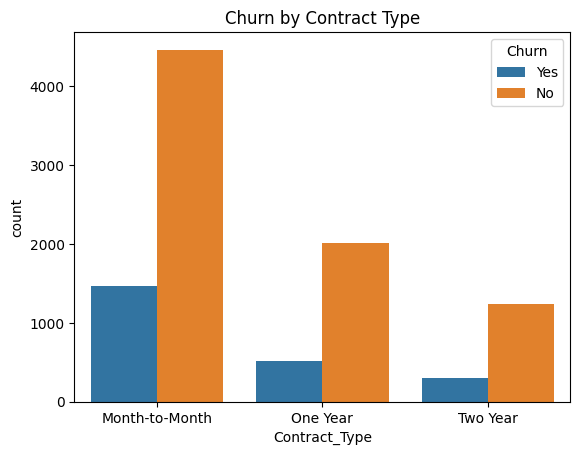

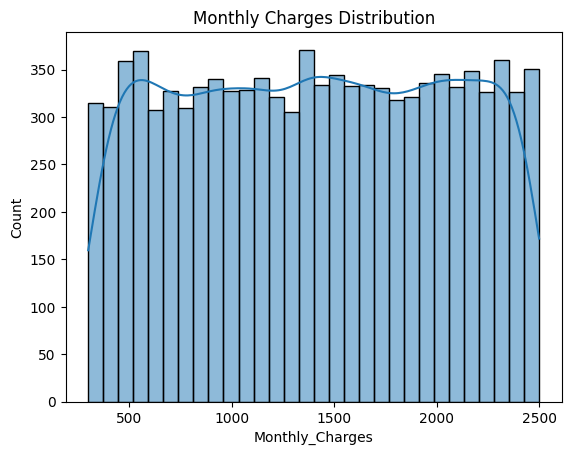

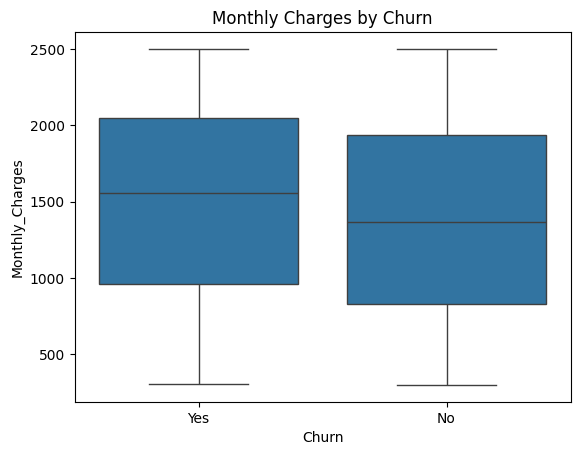

In [15]:
#Churn Rate
chrun_rate = df['Churn'].value_counts(normalize=True)['Yes']
print(f"Churn Rate: {chrun_rate:.2%}")

# Churn by Contract Type
sns.countplot(x='Contract_Type', hue='Churn', data=df)
plt.title("Churn by Contract Type")
plt.show()

# Distribution of Monthly Charges
sns.histplot(df['Monthly_Charges'], bins=30, kde=True)
plt.title("Monthly Charges Distribution")
plt.show()

#Boxplot: Monthly Charges vs Churn
sns.boxplot(x='Churn', y='Monthly_Charges', data=df)
plt.title("Monthly Charges by Churn")
plt.show()

# Feature Engineering

In [16]:
df['avg_monthly'] = df['Total_Charges'] / df['Tenure_Months'].replace(0, 1)
df['high_monthly'] = (df['Monthly_Charges'] > 1500).astype(int)
df['support_issue'] = (df['Customer_Support_Calls'] > 3).astype(int)

# Modelling

In [19]:
# Encode categorical
X = pd.get_dummies(df.drop(columns=['CustomerID','Churn']), drop_first=True)
y = (df['Churn'] == 'Yes').astype(int)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale numeric columns
scaler = StandardScaler()
num_cols = ['Age','Tenure_Months','Monthly_Charges','Total_Charges','Customer_Support_Calls','avg_monthly']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("Logistic Regression:")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, lr.predict_proba(X_test)[:,1]))

# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\nRandom Forest:")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))


Logistic Regression:
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1543
           1       1.00      0.06      0.11       457

    accuracy                           0.78      2000
   macro avg       0.89      0.53      0.49      2000
weighted avg       0.83      0.78      0.70      2000

ROC AUC: 0.5796191170401801

Random Forest:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89      1543
           1       0.97      0.13      0.23       457

    accuracy                           0.80      2000
   macro avg       0.88      0.57      0.56      2000
weighted avg       0.84      0.80      0.74      2000

ROC AUC: 0.5587810270424348


# Feature Importance

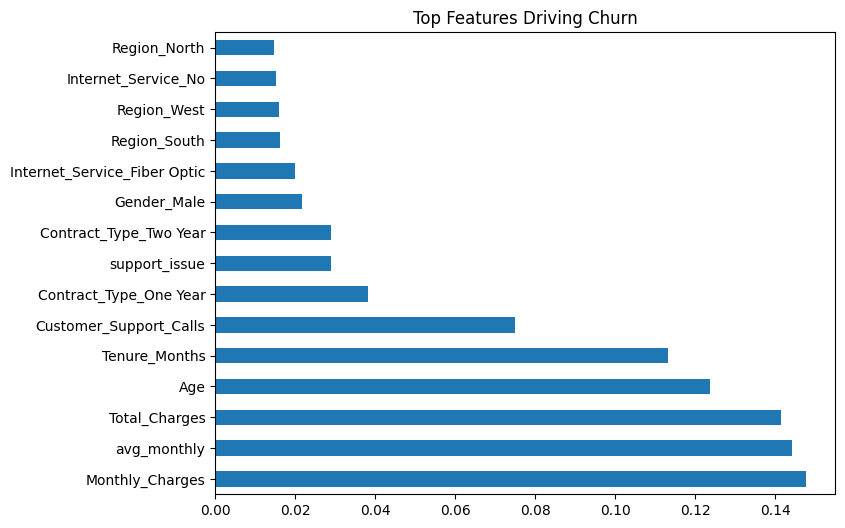

In [20]:
feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(15)
feat_imp.plot(kind='barh', figsize=(8,6))
plt.title("Top Features Driving Churn")
plt.show()

# Export Results

In [21]:
df['Predicted_Churn'] = rf.predict(X)
df.to_csv("telecom_churn_predictions.csv", index=False)

from google.colab import files
files.download("telecom_churn_predictions.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>